# <center>**Corporation Favorita Grocery Sales Prediction**</center>

##### **Author:** MUGISHA Robert
##### **Scrum Master:** Rachael A. Kubi

## **Phase 1: Business Understanding**

### **Problem Statement**

- In the retailer industry, grocery stores are always in a delicate dance with purchasing and sales forecasting. With a little higher prediction, grocers might be stuck with overstocked, perishable goods; however, with a little lower guess, popular items will quickly sell out, and thus leaving money on the table. This prediction problem becomes more important and complex as retailers plan to add new locations with unique needs, new products, and unpredictable product marketing. Considering the comprehensive data on Corporación Favorita, we decided on this grocery corporation as the predicting target.

### **Objective**

- The objective is to create a model that can properly forecast future sales using the thousands of products sold at different Favorita locations, in order to assist the management of the store in formulating inventory and sales plans

### **Approach**
- To guide data analysis project, we will use CRISP-DM (Cross-Industry Standard Process for Data Mining) framework to ensure that our process is systematic and aligned with the project's goals and business needs 

**NOTE:** 
- Throughout this project we will create reusable functions and pipelines to significantly streamline our data analysis project

let's get started!!!

### **Import All Necessary Libraries and Modules**

In [3]:
# Database and Environment handling
import pyodbc
from dotenv import dotenv_values


# data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import stats

# data visualization
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# supressing warnings
import warnings 
warnings.filterwarnings('ignore')

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime as dt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

# modeling
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,Ridge
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV



### **Data Collection**

#### Gathering relevant data from various sources

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('../.env')

# Extract database connection details from environment variables
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
table_1 = environment_variables.get("TABLE_1")
table_2 = environment_variables.get("TABLE_2")
table_3 = environment_variables.get("TABLE_3")

# Create the connection string for SQL Server
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# Establish a connection to the SQL Server database
connection = pyodbc.connect(connection_string)

# Query data for 2020 from the database and load it into a DataFrame
query_1 = f"SELECT * FROM {table_1}"
query_2 = f"SELECT * FROM {table_2}"
query_3 = f"SELECT * FROM {table_3}"

oil = pd.read_sql(query_1, connection)
holidays = pd.read_sql(query_2, connection)
stores = pd.read_sql(query_3, connection)

# Close the database connection
connection.close()

In [6]:

sample = pd.read_csv("../data/sample_submission.csv")
transactions = pd.read_csv("../data/transactions.csv")

# training and testing datasets
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

## **Phase 2: Data Understanding**

### **Data Exploration**

Here I'll Use pandas and descriptive statistics to explore the datasets
- View sample data.
- Check data types
- Dimensionality of the datasets
- Summarize statistics (mean, median, etc.)

In [7]:
# Exploring a dataset
def explore_dataset(df):
    return df.sample(5)

# Checking data types of columns
def check_data_types(df):
    return df.dtypes

# Checking dataset dimensionality
def check_dimensionality(df):
    return df.shape

# Previewing the statistical summary
def preview_statistical_summary(df):
    return df.describe()

#### View Sampled data

In [8]:
datasets = [oil, holidays, stores, sample, transactions, train, test] 
datasets_names = ["Oil", "Holidays", "Stores", "Sample", "Transactions", "Train", "Test"]

for index, dataset in enumerate(datasets):
    print(f"\n\t {datasets_names[index]} Dataset \n \t{len(datasets_names[index].strip())}\n")
    explore_dataset(dataset)


	 Oil Dataset 
 	3


	 Holidays Dataset 
 	8


	 Stores Dataset 
 	6


	 Sample Dataset 
 	6


	 Transactions Dataset 
 	12


	 Train Dataset 
 	5


	 Test Dataset 
 	4



#### Check data types and missing values

In [9]:
check_data_types(train)

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

#### Dimensionality of the datasets

In [10]:
check_dimensionality(test)

(28512, 5)

#### Summarize statistics (mean, median, etc.)


In [11]:
preview_statistical_summary(oil)

,Unnamed: 0,dcoilwtico
count,1218.000000,1175.000000
mean,608.500000,67.714366
std,351.750622,25.630476
min,0.000000,26.190001
25%,304.250000,46.405001
50%,608.500000,53.189999
75%,912.750000,95.660000
max,1217.000000,110.620003


## **Phase 3: Data Preparation**

### **Data Cleaning**

- merging Datasets
- check data types and conversions
- check and handle duplicated data
- addressing missing or invalid data
- filtering to the desired subset of data
- renaming columns
- saving clean dataset

In [12]:
# Renaming columns
def rename_columns(df, column_mapping):
    return df.rename(columns=column_mapping)

# convert to numeric
def convert_to_numeric(df, numerical_cols):
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')
    return df

# convert to datetime
def convert_to_datetime(df, date_cols):
    df[date_cols] = pd.to_datetime(df[date_cols], errors='coerce')
    return df

# conver to float
def convert_to_float(df, float_cols):
    df[float_cols] = df[float_cols].astype(float)
    return df

# check duplicates 
def check_duplicates(df):
    return df.duplicated().sum()

# Handling duplicates (dropping)
def drop_duplicates(df):
    return df.drop_duplicates()

# Visualizing missing values
def visualize_missing_values(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.show()

# Checking missing values
def check_missing_values(df):
    return df.isnull().sum()

# Drop missing values
def drop_missing_values(df):
    return df.dropna()

# imputing missing values using scikit-learn
def impute_missing_values(df, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Checking outliers
def check_outliers(df, column, z_threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    return (z_scores.abs() > z_threshold).sum()

def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -degree) | 
    (data['zscore'] >= degree)]
    
    return outliers['value'], data

# Visualizing outliers
def visualize_outliers(df, column):
    plt.figure(figsize=(8, 4))
    df.boxplot(column=column)
    plt.show()

# Handling outliers (clipping)
def handle_outliers(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Dropping unnecessary columns
def drop_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop)

# Merging datasets
def merge_datasets(df1, df2, on_column):
    return pd.merge(df1, df2, on=on_column)

# Save cleaned dataframe as csv
def save_as_csv(df, filename):
    df.to_csv(filename, index=False)

#### **Merging datasets**

In [13]:
merge_d1 = merge_datasets(train, transactions, ['date', 'store_nbr'])

In [14]:
merge_d2 = merge_datasets(merge_d1, holidays, 'date')

In [15]:
merge_d3 = merge_datasets(merge_d2, oil, 'date')

In [16]:
data = merge_datasets(merge_d3, stores, 'store_nbr')

In [17]:
data.head(5)

,id,date,store_nbr,family,sales,onpromotion,transactions,Unnamed: 0_x,type_x,locale,locale_name,description,transferred,Unnamed: 0_y,dcoilwtico,Unnamed: 0,city,state,type_y,cluster
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770,41,Holiday,National,Ecuador,Primer dia del ano,False,0,NaN,24,Salinas,Santa Elena,D,1
1,562,2013-01-01,25,BABY CARE,0.0,0,770,41,Holiday,National,Ecuador,Primer dia del ano,False,0,NaN,24,Salinas,Santa Elena,D,1
2,563,2013-01-01,25,BEAUTY,2.0,0,770,41,Holiday,National,Ecuador,Primer dia del ano,False,0,NaN,24,Salinas,Santa Elena,D,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,770,41,Holiday,National,Ecuador,Primer dia del ano,False,0,NaN,24,Salinas,Santa Elena,D,1
4,565,2013-01-01,25,BOOKS,0.0,0,770,41,Holiday,National,Ecuador,Primer dia del ano,False,0,NaN,24,Salinas,Santa Elena,D,1


#### **Renaming columns**

In [18]:
cols_mapping = {
    "store_nbr": "store_number",
    "type_x": "st_type",
    "dcoilwtico": "oil_price",
    "type_y": "holiday_type",
}
data = rename_columns(data, cols_mapping)

In [19]:
data.columns

Index(['id', 'date', 'store_number', 'family', 'sales', 'onpromotion',
       'transactions', 'Unnamed: 0_x', 'st_type', 'locale', 'locale_name',
       'description', 'transferred', 'Unnamed: 0_y', 'oil_price', 'Unnamed: 0',
       'city', 'state', 'holiday_type', 'cluster'],
      dtype='object')

#### **Filtering to desired subets of data**

In [20]:
cols_to_drop = list(set(data.columns) - set(['date',  'store_number', 'family', 'sales',
       'onpromotion', 'city', 'state', 'st_type', 'cluster', 'oil_price', 'transactions',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred']))
print(cols_to_drop)

data = drop_columns(data, cols_to_drop)

['Unnamed: 0', 'id', 'Unnamed: 0_y', 'Unnamed: 0_x']


#### **Check data types and conversions**

In [21]:
check_data_types(data)

date             object
store_number      int64
family           object
sales           float64
onpromotion       int64
transactions      int64
st_type          object
locale           object
locale_name      object
description      object
transferred        bool
oil_price       float64
city             object
state            object
holiday_type     object
cluster           int64
dtype: object

In [22]:
data['date']= convert_to_datetime(data, 'date')['date']

In [23]:
num_cols = ['onpromotion', 'transferred']
data = convert_to_numeric(data, num_cols)

#### **Check and handle duplicated data**

In [24]:
check_duplicates(data)

0

#### **Addressing missing or invalid data**

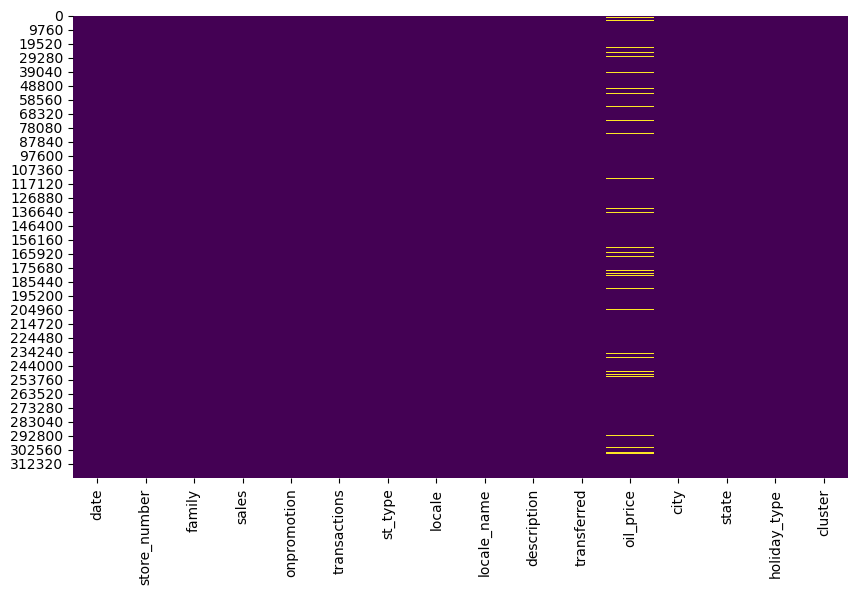

In [25]:
visualize_missing_values(data)

In [26]:
check_missing_values(data)

date                0
store_number        0
family              0
sales               0
onpromotion         0
transactions        0
st_type             0
locale              0
locale_name         0
description         0
transferred         0
oil_price       22044
city                0
state               0
holiday_type        0
cluster             0
dtype: int64

In [27]:
data.isnull().sum() / len(data)

date            0.00000
store_number    0.00000
family          0.00000
sales           0.00000
onpromotion     0.00000
transactions    0.00000
st_type         0.00000
locale          0.00000
locale_name     0.00000
description     0.00000
transferred     0.00000
oil_price       0.06845
city            0.00000
state           0.00000
holiday_type    0.00000
cluster         0.00000
dtype: float64

In [28]:
data = drop_missing_values(data)

#### **Saving clean dataset**

In [29]:
save_as_csv(data, "../data/clean_dataset.csv")

## **Phase 4: Exploratory Data Analysis**

### **Hypothesis Testing**

##### **Hypothesis 1:**
- Null: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.
- Alternate: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

##### **Hypothesis 2:**
- Null: Sales dont increase over time.
- Alternate: Sales increase with time.

##### **Hypothesis 3:**
- Null: Situating a startup in a particular city does not influence funding.
- Alternate: Situating a startup in a particular city significantly affects funding.

##### **Hypothesis 4:**
- Null: Transactions don't have an impact on sales.
- Alternate: The more the transactions the higher the sales.

### **Univariate Analysis**

##### Sales

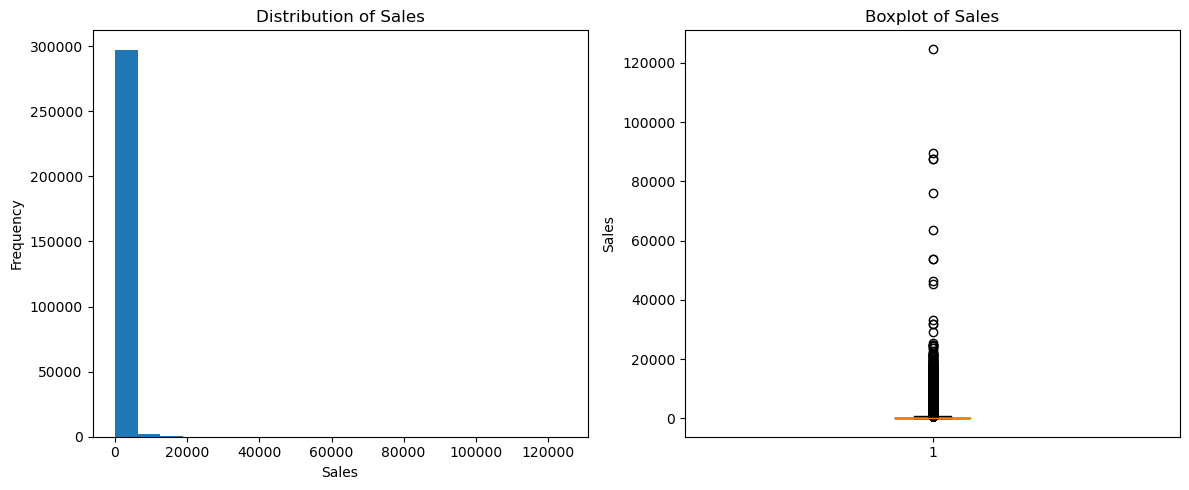

In [30]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(data['sales'], bins=20)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sales')

# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(data['sales'])
ax2.set_ylabel('Sales')
ax2.set_title('Boxplot of Sales')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

##### **Observation:**
- Sales is positively skewed.
- The median value is thus closer to the first quartile.
- The boxplot shows presence of very extreme values.
- There is a high range between the values. 


##### Oil Prices

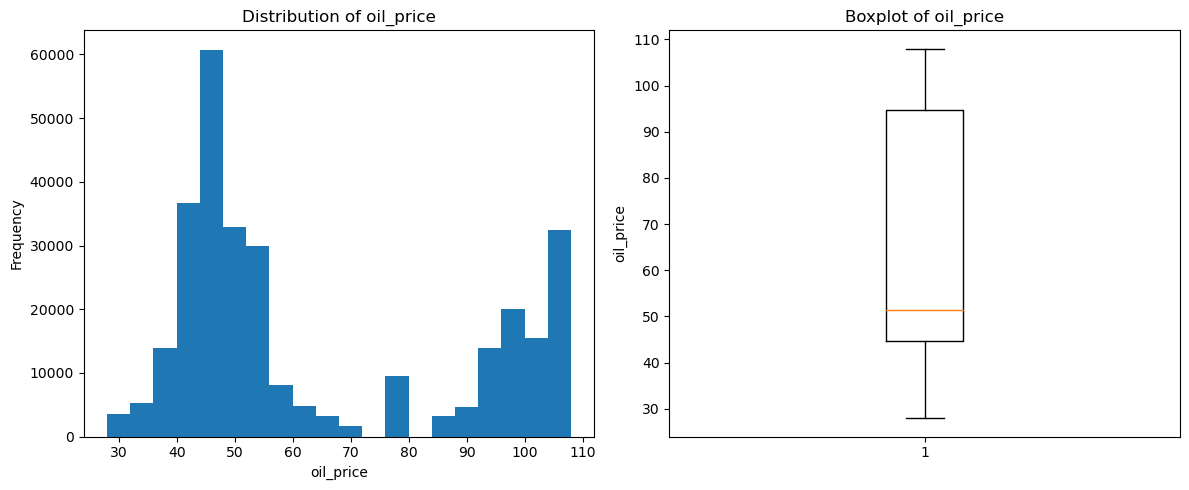

In [31]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(data['oil_price'], bins=20)
ax1.set_xlabel('oil_price')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of oil_price')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(data['oil_price'])
ax2.set_ylabel('oil_price')
ax2.set_title('Boxplot of oil_price')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

##### **Observation:**
- The histogram displays a bimodal distribution characterized by two prominent peaks.
- The first peak is observed in the interval between 40 and 55, indicating a concentration of data points in this range.
- This suggests that a significant portion of the dataset falls within this range, leading to a higher frequency count within this interval.


##### Onpromotion


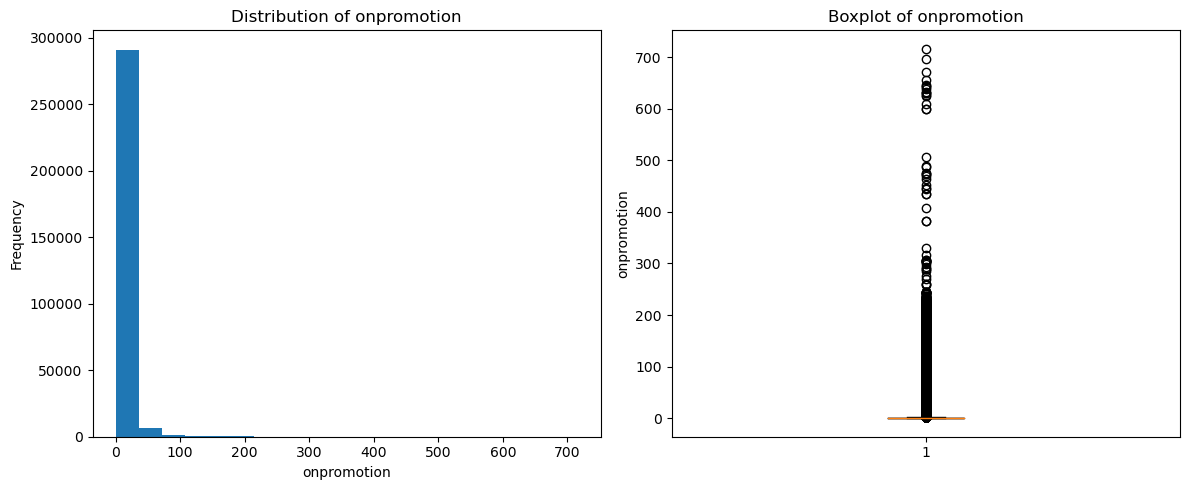

In [32]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(data['onpromotion'], bins=20)
ax1.set_xlabel('onpromotion')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of onpromotion')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(data['onpromotion'])
ax2.set_ylabel('onpromotion')
ax2.set_title('Boxplot of onpromotion')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

##### **Observation:**
- onpromotion is positively skewed.
- The median value is thus closer to the first quartile.
- The boxplot shows presence of very extreme values.
- There is a high range between the values. 

### **Bivariate Analysis**

##### Trend of Daily average sales

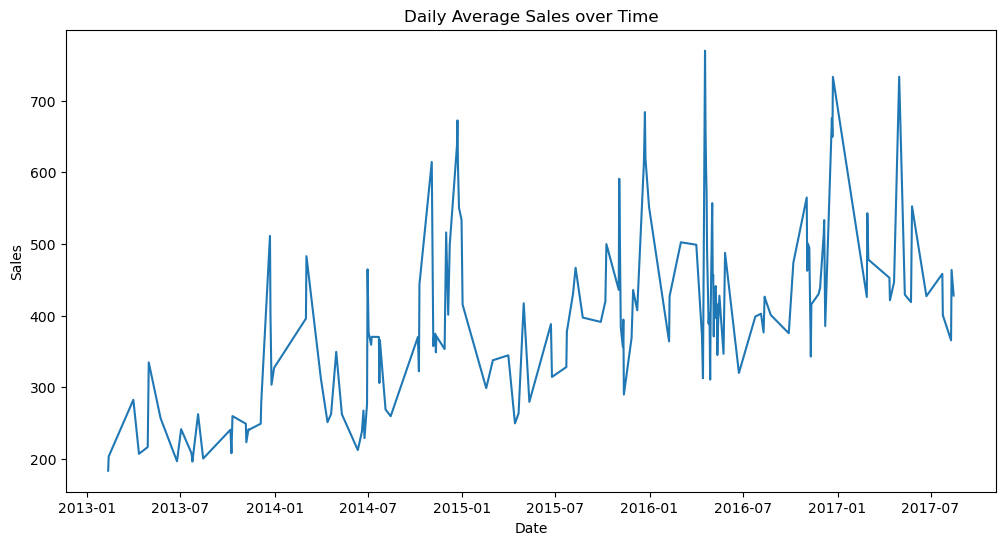

In [33]:
# Converting the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Grouping the sales data by date and calculating the mean sales for each day
data_daily = data.groupby('date')['sales'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average sales over time
plt.plot(data_daily.index, data_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Sales')

# Adding a title to the plot
plt.title('Daily Average Sales over Time')

# Displaying the plot
plt.show()



##### **Observation**

- Daily average sales exhibit an upward trend over the years, except from 2017.

- There are some seasonal peaks in each year as well, especially at the end of each year. 

##### Trend of Daily Average Oil Prices

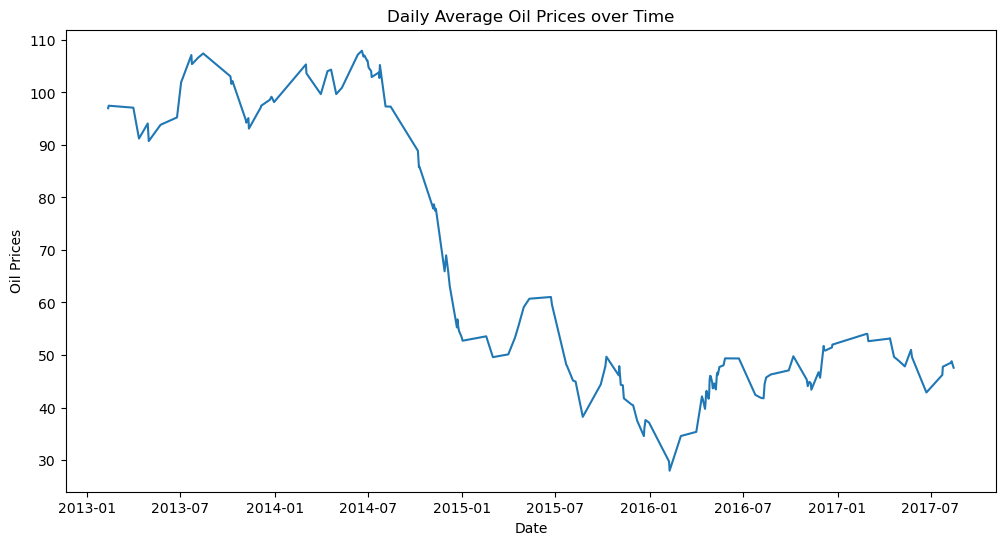

In [34]:
# Converting the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Grouping the data by date and calculating the mean oil prices for each day
data_daily = data.groupby('date')['oil_price'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average oil prices over time
plt.plot(data_daily.index, data_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Oil Prices')

# Adding a title to the plot
plt.title('Daily Average Oil Prices over Time')

# Displaying the plot
plt.show()

##### **Observation:**

- Trend in Oil Prices:
The data indicates that there was a notable decrease in oil prices from 2013 to 2015, with the price dropping significantly by more than half. This likely reflects the global decline in oil prices that occurred during this period.

- Stability and Recovery:
The oil prices seem to have stabilized and slightly recovered from 2016 to 2017. While they are still lower than the earlier years, the trend shows a moderate increase.

##### Daily Average Oil Prices over Time

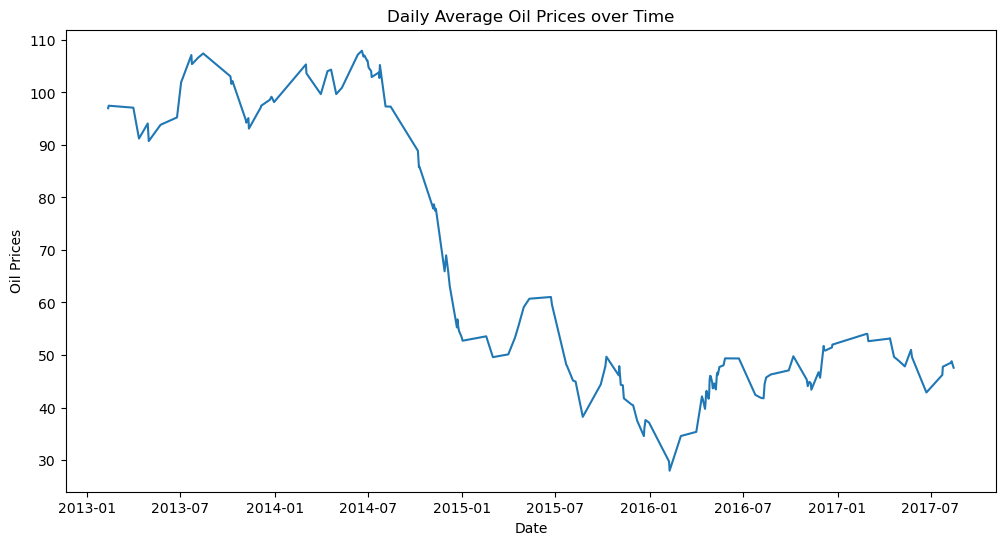

In [35]:
#Visualizating the backward fill
# Converting the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Grouping the data by date and calculating the mean oil prices for each day
data_daily = data.groupby('date')['oil_price'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average oil prices over time
plt.plot(data_daily.index, data_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Oil Prices')

# Adding a title to the plot
plt.title('Daily Average Oil Prices over Time')

# Displaying the plot
plt.show()

##### Sales against holiday type

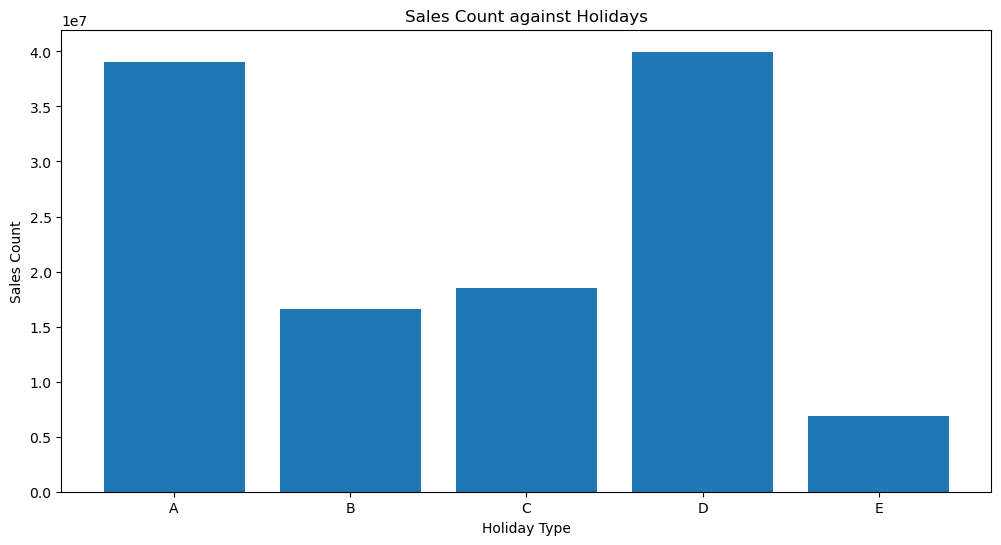

In [36]:
# Converting the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Grouping the sales data by holiday type and calculating the sum of sales for each holiday type
data_daily = data.groupby('holiday_type')['sales'].sum()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a bar plot of sales count against holiday types
plt.bar(data_daily.index, data_daily.values)

# Adding a label to the x-axis
plt.xlabel('Holiday Type')

# Adding a label to the y-axis
plt.ylabel('Sales Count')

# Adding a title to the plot
plt.title('Sales Count against Holidays')

# Displaying the plot
plt.show()

##### **Observations:**

- Sales Distribution:
The data indicates how sales are distributed across different holiday types. Some holiday types, like 'Holiday' and 'Event,' have significantly higher sales counts compared to others.

- Impact of Holidays:
It's evident that holidays, whether they are 'Additional,' 'Event,' or traditional 'Holiday' types, contribute significantly to sales. 'Event' and 'Holiday' holidays, in particular, seem to have a substantial impact on sales.

- Variation in Sales:
The variation in sales counts across different holiday types suggests that some holidays are more commercially impactful than others. This could be due to various factors, such as increased consumer spending during certain holiday periods or specific sales promotions associated with particular holiday types

##### Sales against store number

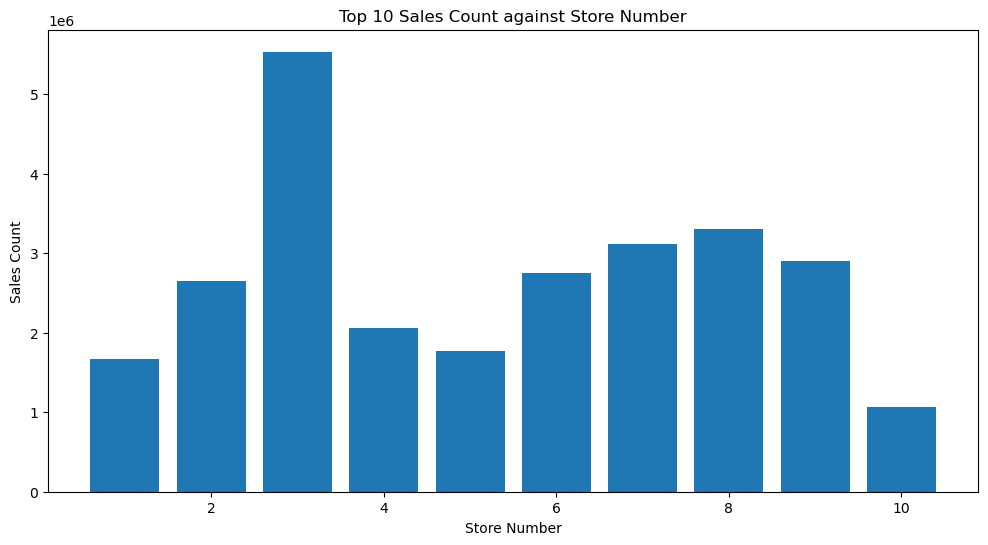

In [37]:
data['date']=pd.to_datetime(data['date'])
data_daily=data.groupby('store_number')['sales'].sum().head(10)
data_daily= data_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(data_daily.index,data_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Store Number')
plt.show()

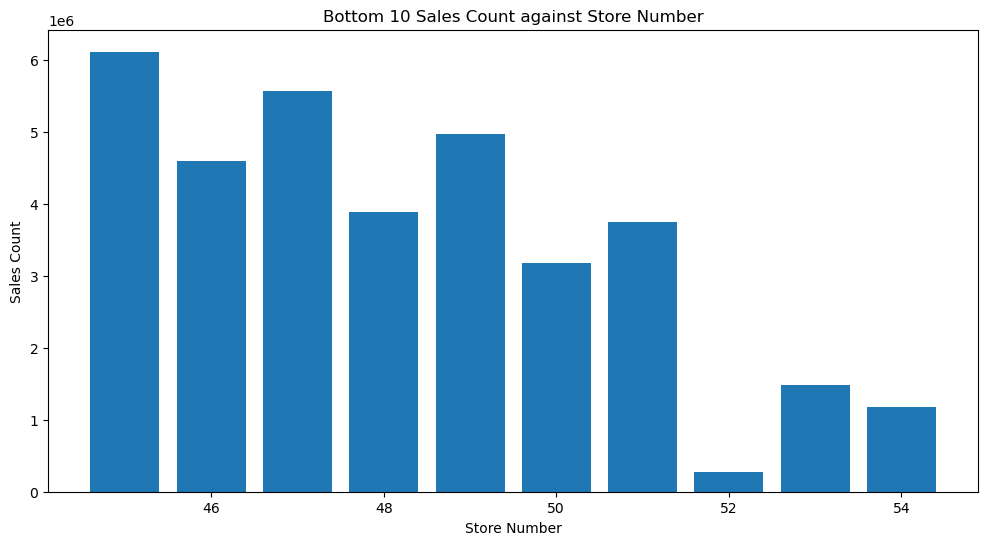

In [38]:
data['date']=pd.to_datetime(data['date'])
data_daily=data.groupby('store_number')['sales'].sum().tail(10)
data_daily= data_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(data_daily.index,data_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Bottom 10 Sales Count against Store Number')
plt.show()

##### **Observation**
- After displaying both the top 10 and bottom 10 most store salers the highest store seller was store number 3 and the bottom store seller being store number 52. 

##### Sales against Product

Text(0.5, 1.0, 'Top 10 Sales Count against Product Sold')

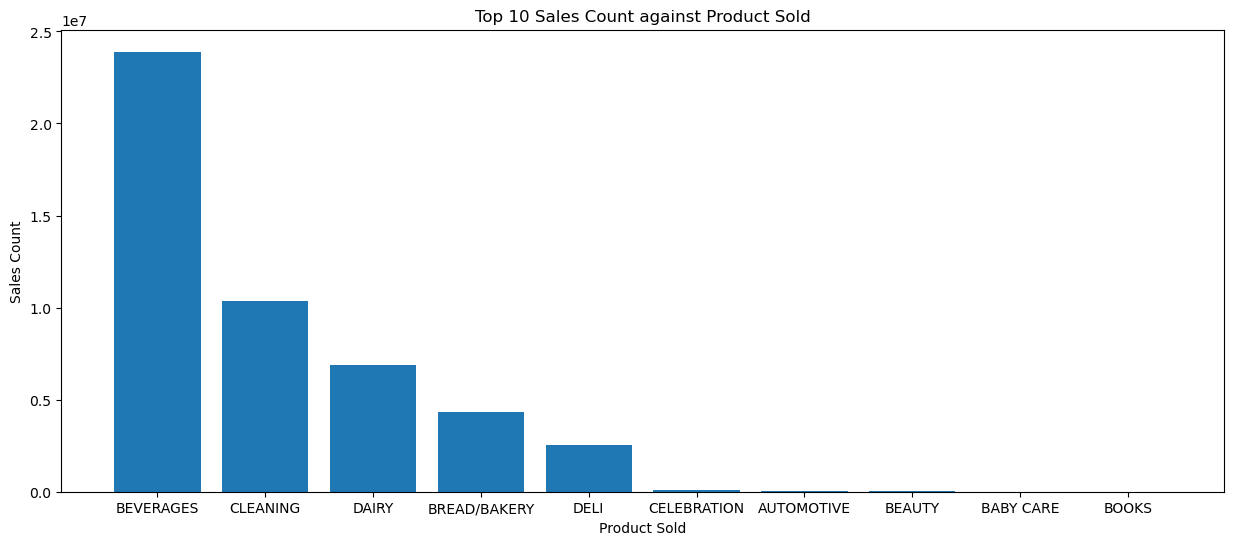

In [39]:
data['date']=pd.to_datetime(data['date'])
data_daily=data.groupby('family')['sales'].sum().head(10)
data_daily= data_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(data_daily.index,data_daily.values)
plt.xlabel('Product Sold')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Product Sold')

##### **Observations**
- After displaying the top 10 product with most sales beverages were the leading products followed by cleaning products 

##### Sales against State

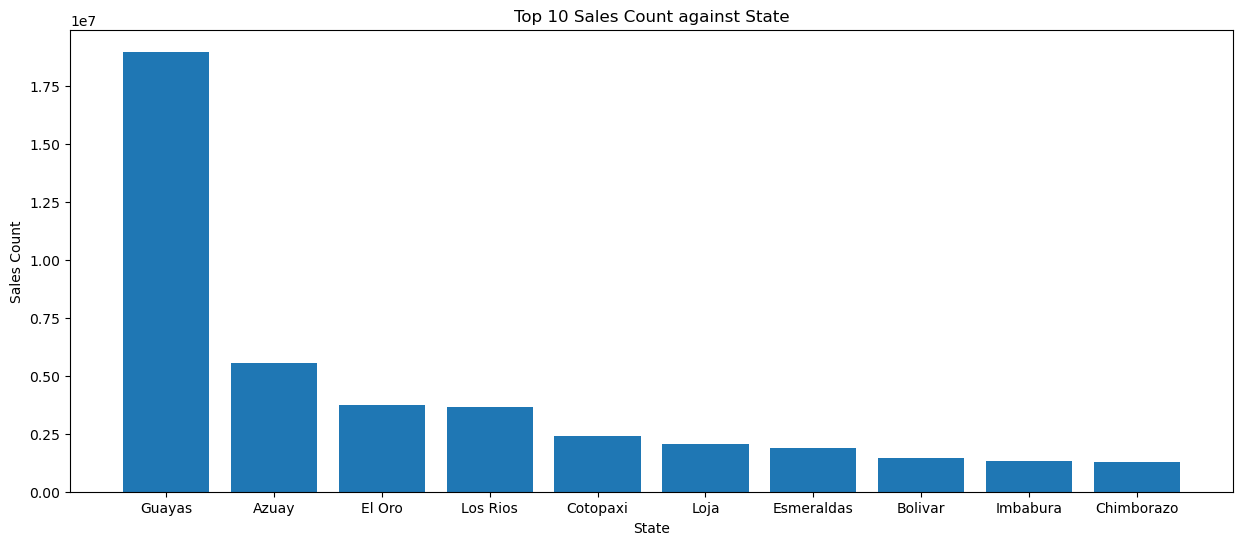

In [40]:
data['date']=pd.to_datetime(data['date'])
data_daily=data.groupby('state')['sales'].sum().head(10)
data_daily= data_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(data_daily.index,data_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')
plt.show()

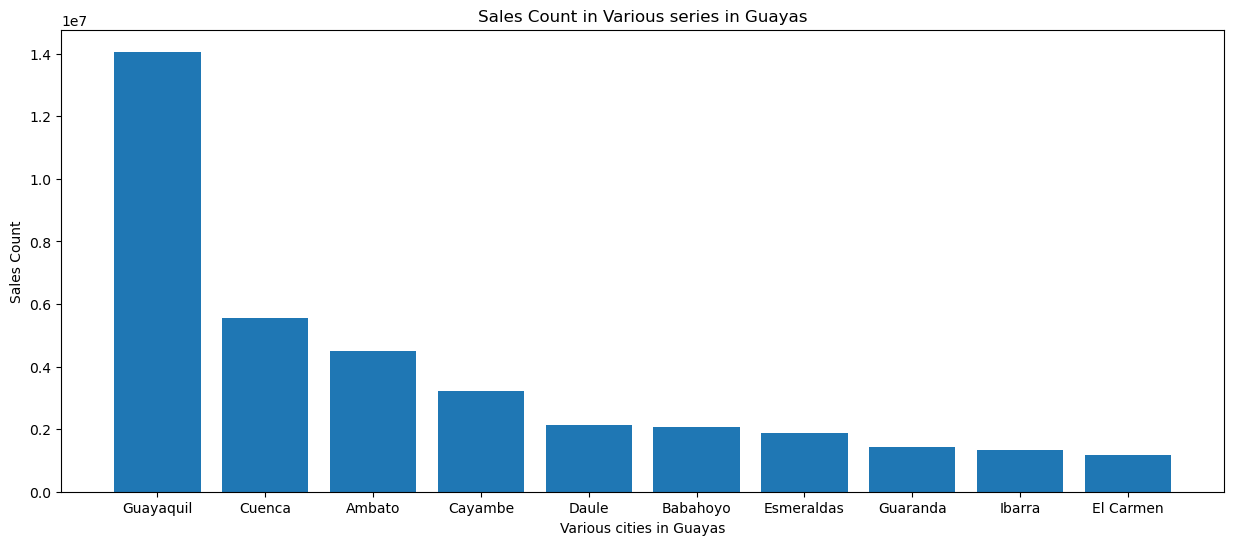

In [41]:
data['date']=pd.to_datetime(data['date'])
data_daily=data[data['state']=='Guayas']
data_daily=data.groupby('city')['sales'].sum().head(10)
data_daily= data_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(data_daily.index,data_daily.values)
plt.xlabel('Various cities in Guayas')
plt.ylabel('Sales Count')
plt.title('Sales Count in Various series in Guayas')
plt.show()

##### **Observation**
- Most sales where recorded in the state of Guayas. Given the state of Guayas the highest city with most sales in Guayas is Guayaquil 

##### Sales against type

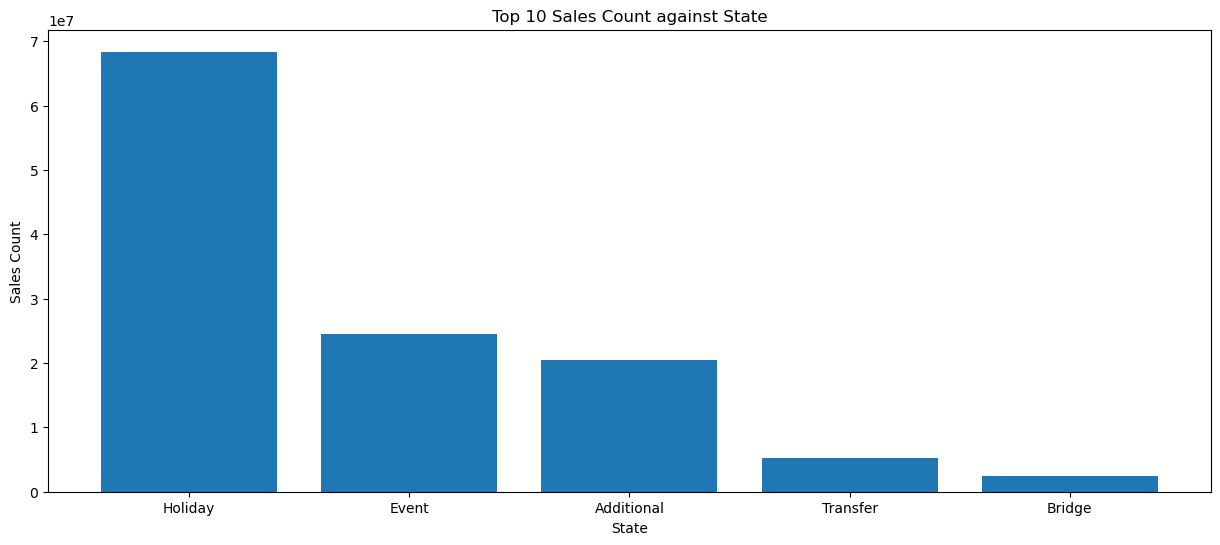

In [42]:
# 'type' : 'st_type'
data['date']=pd.to_datetime(data['date'])
data_daily=data.groupby('st_type')['sales'].sum().head(10)
data_daily= data_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(data_daily.index,data_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')
plt.show()

##### **Observation**
- Most sales where related to product of type D and the least of product type E 

### **Time Series Analysis of sales by resampling**

<Axes: xlabel='store_number', ylabel='sales'>

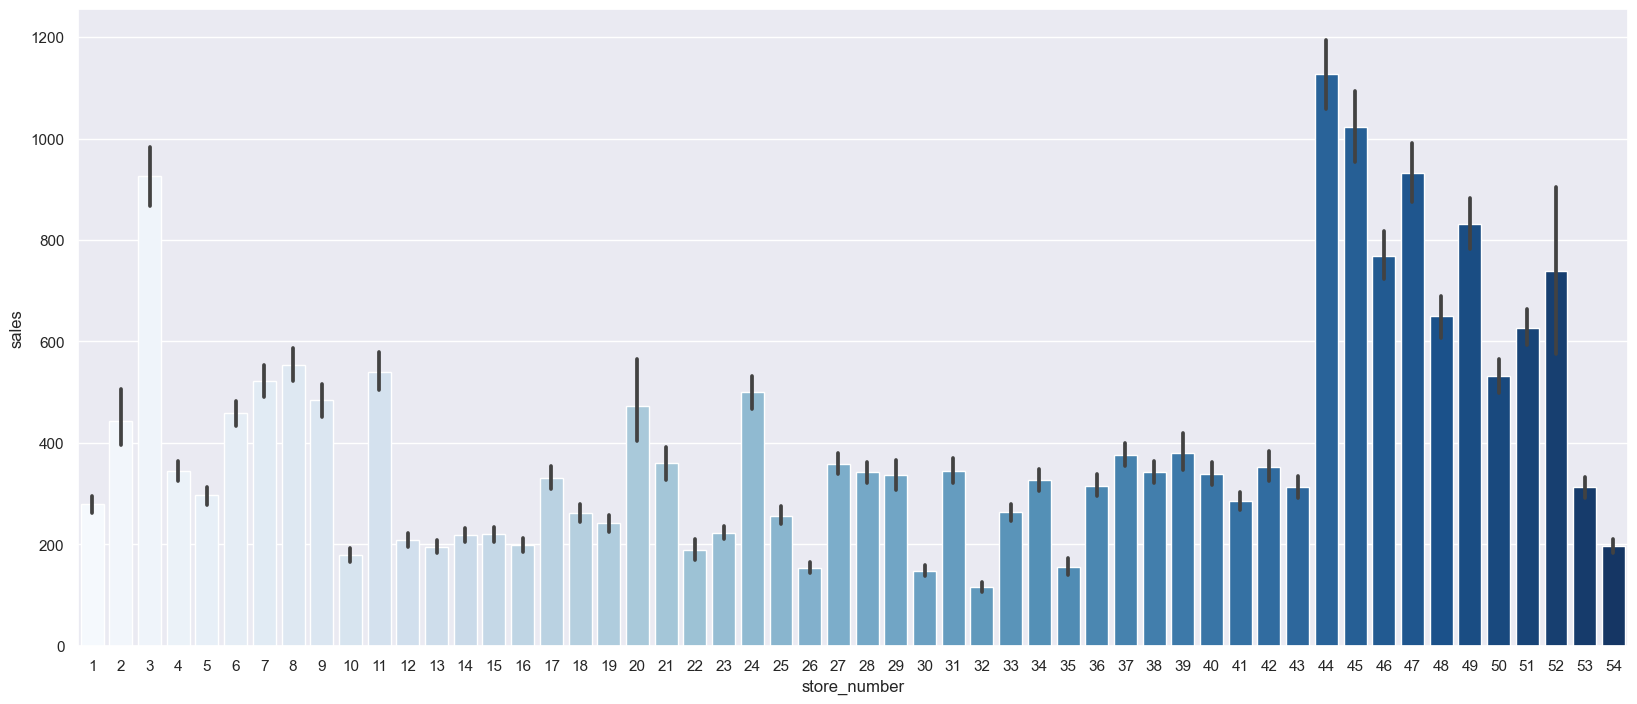

In [43]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.barplot(x = 'store_number',y = 'sales',data = data,palette = "Blues")

<Axes: xlabel='transactions', ylabel='sales'>

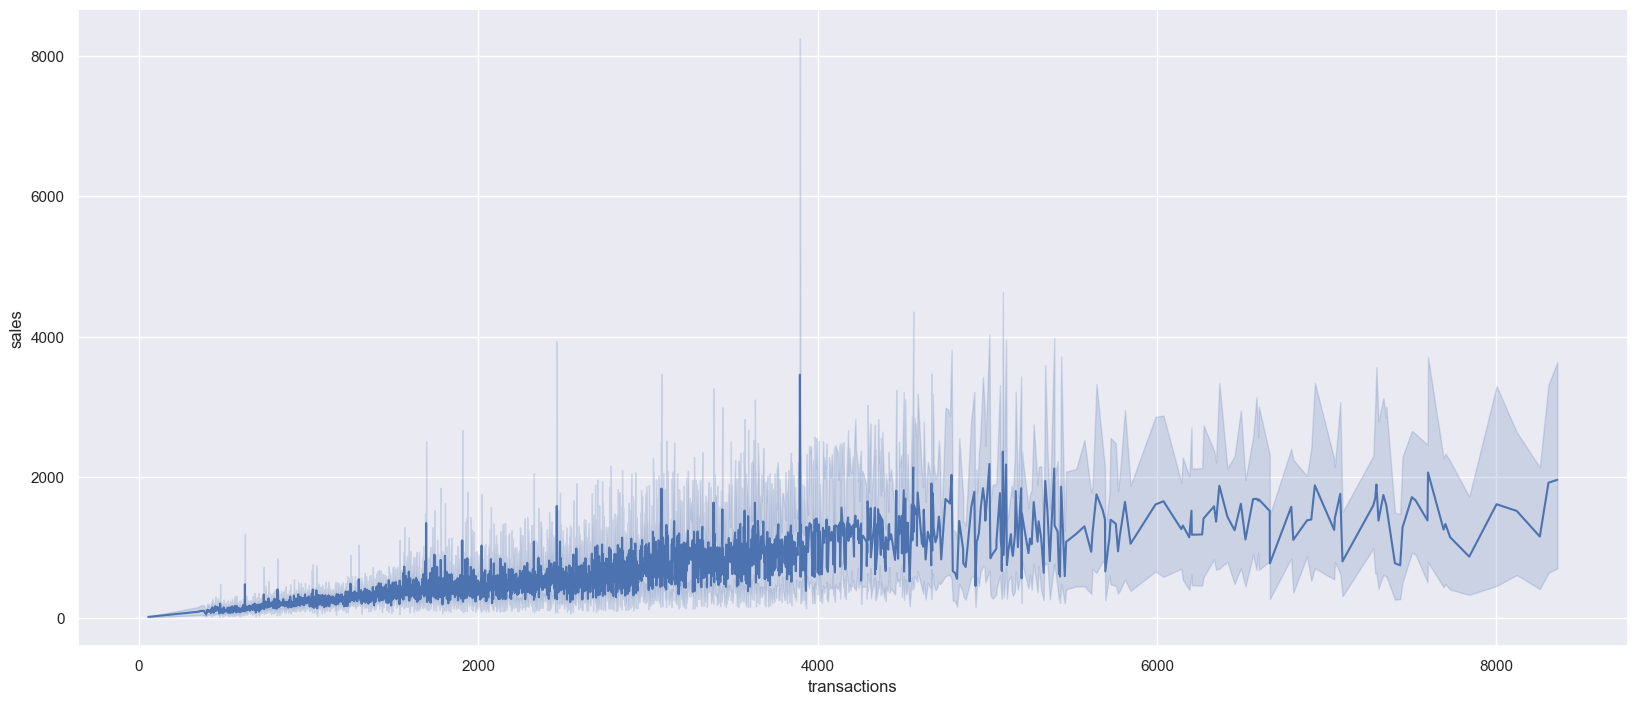

In [44]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.lineplot(x = "transactions",y = 'sales',data = data,palette = "Blues")

In [45]:
go

<module 'plotly.graph_objects' from 'c:\\Users\\Hp\\AppData\\Local\\conda\\conda\\envs\\robert\\lib\\site-packages\\plotly\\graph_objects\\__init__.py'>

We visualize the time series of sales across time

In [46]:
# Choose date and sales columns
timeseriesdata=data[['sales','date']]
timeseriesdata.index = timeseriesdata['date']
timeseriesdata
# make date the index
del timeseriesdata['date']
timeseriesdata

,sales
date,
2013-02-11,0.000
2013-02-11,0.000
2013-02-11,2.000
2013-02-11,4092.000
2013-02-11,0.000
...,...
2017-08-15,397.340
2017-08-15,104.418
2017-08-15,3803.368


##### Yearly Series of Total Sales

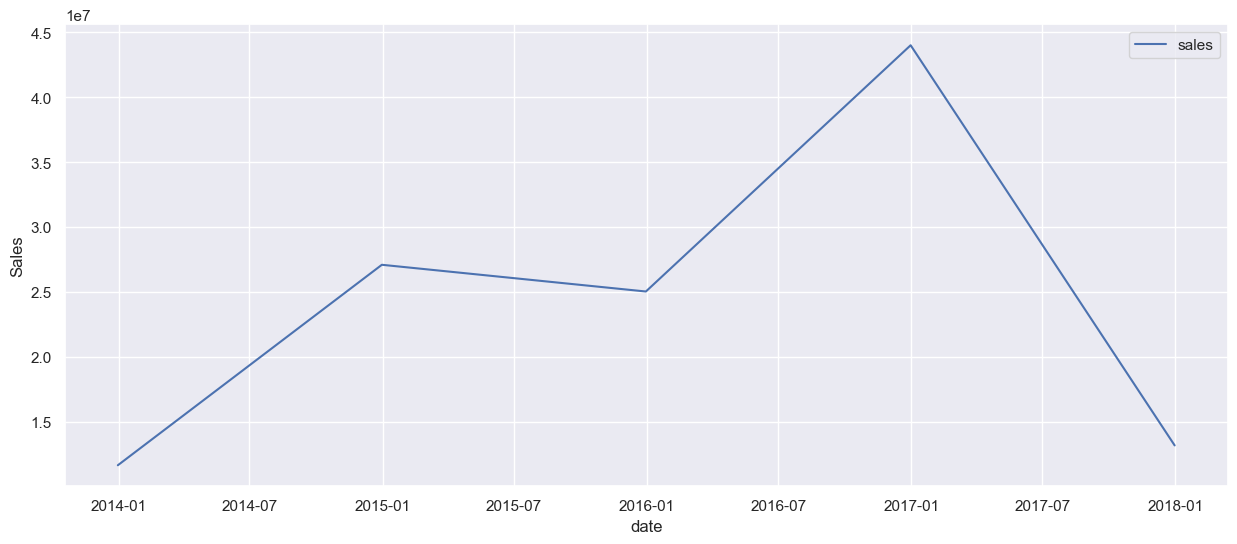

In [47]:
sales_per_year= timeseriesdata.resample('Y').sum()
plt.figure(figsize= (15,6))
sns.lineplot(sales_per_year)
plt.ylabel('Sales')
plt.show()

##### Analyzing monthly sales across each year

In [48]:
timeseriesdata= timeseriesdata.resample('M').sum()

##### Year 2013

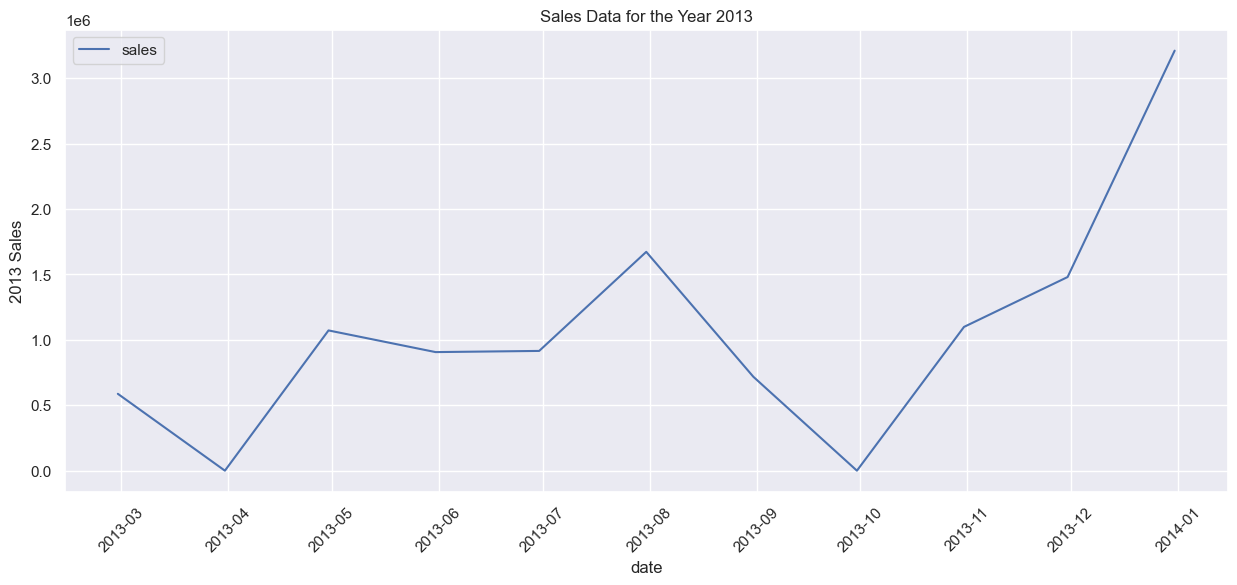

In [49]:
data2013 = timeseriesdata[timeseriesdata.index.year == 2013]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2013)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2013 Sales')
plt.title('Sales Data for the Year 2013')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()

##### Year 2014

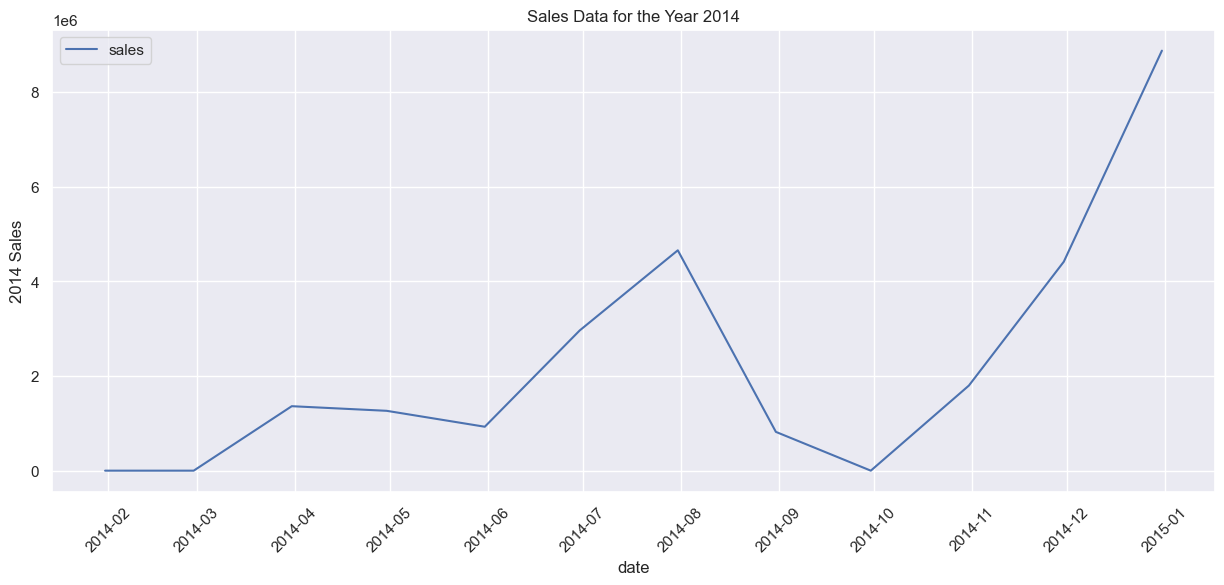

In [50]:
data2014 = timeseriesdata[timeseriesdata.index.year == 2014]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2014)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2014 Sales')
plt.title('Sales Data for the Year 2014')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()

##### Year 2015

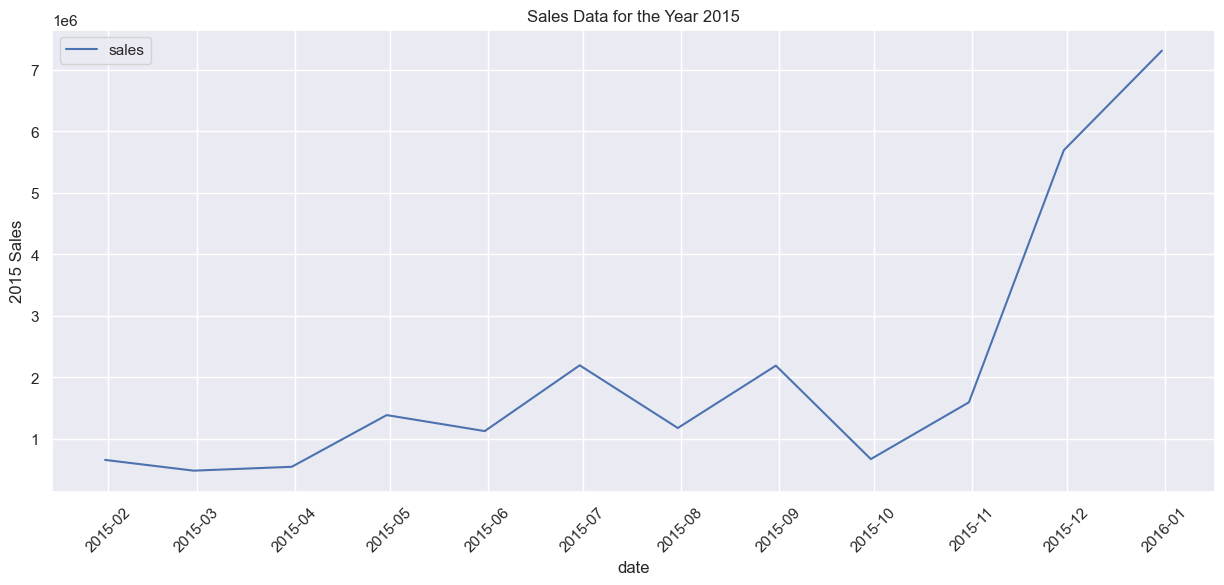

In [51]:
data2015 = timeseriesdata[timeseriesdata.index.year == 2015]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2015)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2015 Sales')
plt.title('Sales Data for the Year 2015')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()

##### Year 2016

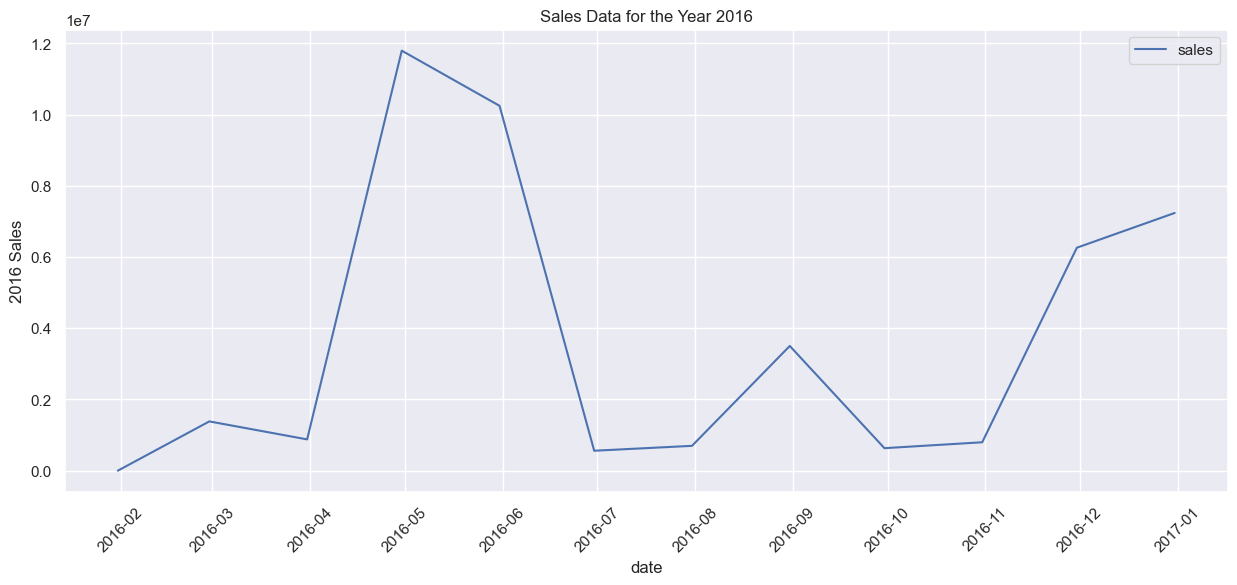

In [52]:
data2016 = timeseriesdata[timeseriesdata.index.year == 2016]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2016)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2016 Sales')
plt.title('Sales Data for the Year 2016')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()

##### Year 2017

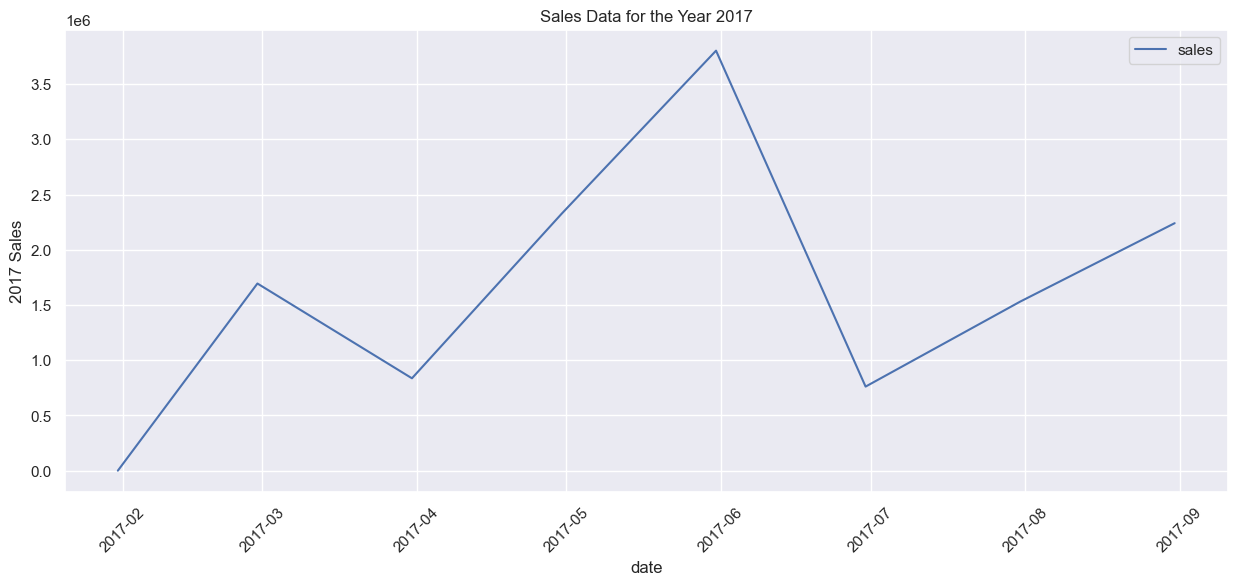

In [53]:
data2017 = timeseriesdata[timeseriesdata.index.year == 2017]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2017)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2017 Sales')
plt.title('Sales Data for the Year 2017')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()

##### Sales series across months

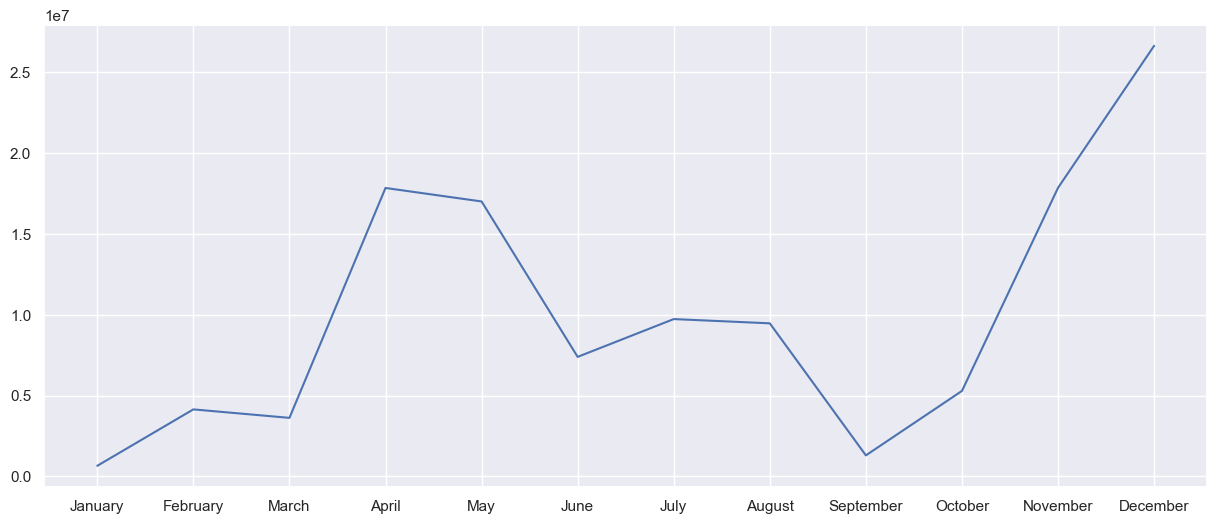

In [54]:
# Group by month and calculate the sum of sales
monthly_sales = data.groupby(data['date'].dt.strftime('%B'))['sales'].sum()
# List of month names in order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Convert month names to categorical with specified order
monthly_sales.index = pd.Categorical(monthly_sales.index, categories=month_order, ordered=True)
# Sort the index to order the months
monthly_sales = monthly_sales.sort_index()
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
plt.plot(monthly_sales)
plt.show()



#### **Observation:**
- The sales start increasing from september but exponentionally increase from October to December and from March to April. The highest purchases where witnessed in December and the lowest in September. 

##### Sales Series in Date

In [55]:
data['date']=pd.to_datetime(data['date'])
daily_sales = data.groupby(data['date'].dt.day)['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

##### **Generation:** 
- The highest sales are recorded at the beginning and at the end of the month. 

####  MultiVariate Analysis

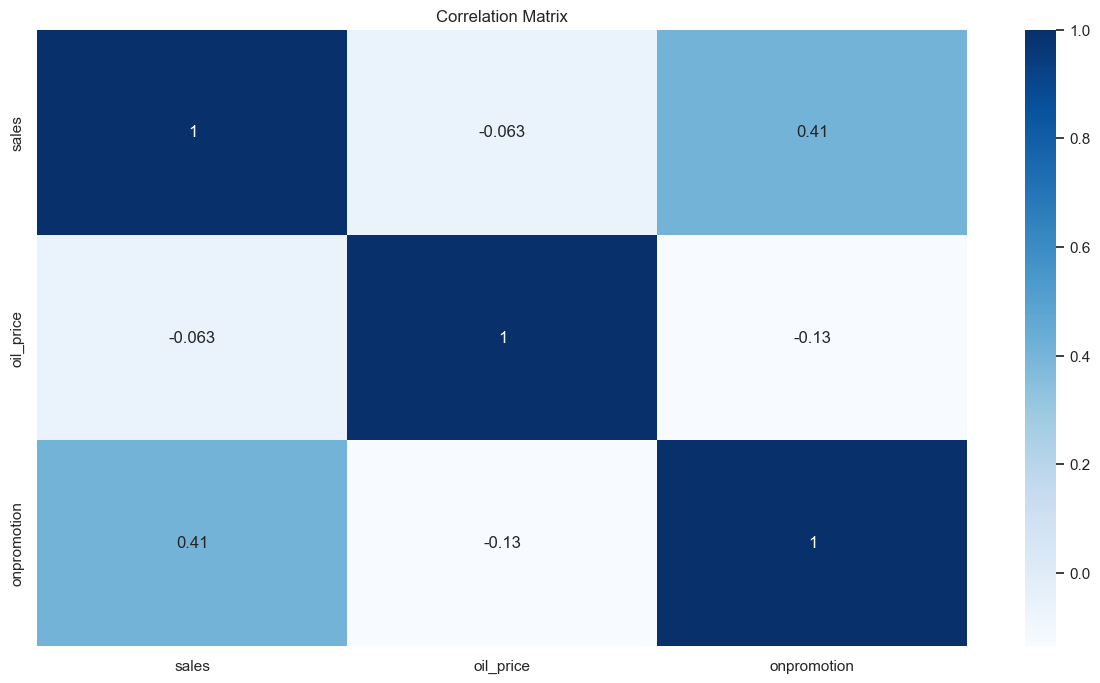

In [56]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales','oil_price','onpromotion']

# Compute correlation matrix
corr_matrix = data[numerical_vars].corr()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

##### **Observation:**
- There is a significant positive relationship between number of items on promotion with slaes as well as a weak negative relation with oil and sales. 

### **Answering Hypothesis Questions**

#### Question 1: Is the dataset complete?

#### Question 2: Did the earthquake impact sales?

### **Testing Hypothesis**

##### Before hypothesis testing we explore the distribution of sales. Using shapiro wilk test to explore distribution.

In [57]:
# Group the data by 'Year Funded'
grouped_data = data.groupby('date')['sales'].sum()
# Perform Shapiro-Wilk test for each group
statistic, p_value = stats.shapiro(grouped_data)
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print("The data does not follow a normal distribution.")
else:
    print("The data follows a normal distribution.")

Shapiro-Wilk Test Results:
Statistic: 0.8230803608894348
P-value: 6.624449253034292e-13
The data does not follow a normal distribution.


**Observation:**
- The p-value is below 0.05 therefore, the sales do not follow normal distribution hence non parametric ANOVA will be used.

##### **Hypothesis 1:**

**Null**: 
- The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

**Alternate:**
- The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

In [58]:
 
#for this example we will use the Pearson Correlation.
alpha = 0.05
pearson_coef, p_value = stats.pearsonr(data["sales"], data["onpromotion"])
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", round(p_value,3) )
if p_value < alpha:
    print("Reject the null hypothesis. The promotional activities have a significant impact on store sales for Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. The promotional activities dont have a significant impact on store sales for Corporation Favorita..")



Pearson Correlation Coefficient:  0.408898052042345 and a P-value of: 0.0
Reject the null hypothesis. The promotional activities have a significant impact on store sales for Corporation Favorita.


In [59]:
def perform_anova(data_frame, column_name, value_column):
    groups = data_frame[column_name].unique()
    group_data = [data_frame.query(f'{column_name}=="{group}"')[value_column] for group in groups]
    fvalue, pvalue = stats.f_oneway(*group_data)
    return pvalue

# Assuming data is your DataFrame containing the "sales" and "holiday_type" columns
p_value = perform_anova(data, 'holiday_type', 'sales')

print("p_value:", round(p_value, 3))
if p_value < alpha:
    print("Reject the null hypothesis. The holidya_types have a significant impact on store sales for Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. The holiday_types dont have a significant impact on store sales for Corporation Favorita..")


p_value: 0.0
Reject the null hypothesis. The holidya_types have a significant impact on store sales for Corporation Favorita.


#### **Conclusion**
- The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

##### **Hypothesis 2:**
**Null:**
- Sales do not increase over time.

**Alternate:**
- Sales increase with time.

In [60]:
amounts_per_year=data.groupby("date")['sales'].apply(list)
amount_year = np.array(amounts_per_year)

# Perform one-way ANOVA
test_statistic, p_value = stats.kruskal(*amount_year)
print(f"P_value: {p_value}")


# Interpret the results
if p_value < alpha:
    print("Reject the null hypothesis concluding that sales increase with time.")
else:
    print("Fail to reject the null hypothesis concluding that sales dont increase with time.")



P_value: 0.0
Reject the null hypothesis concluding that sales increase with time.


#### **Conclusion:**
- The sales increase over time for Corporation Favorita. 

#### **Hypothesis 3:**

**Null:**
- Situating a startup in a particular city does not influence sales.

**Alternate:**
- Situating a startup in a particular city significantly affects sales.

In [61]:
def perform_anova(data_frame, column_name, value_column):
    groups = data_frame[column_name].unique()
    group_data = [data_frame.query(f'{column_name}=="{group}"')[value_column] for group in groups]
    fvalue, pvalue = stats.f_oneway(*group_data)
    return pvalue

# Assuming data is your DataFrame containing the "sales" and "holiday_type" columns
p_value = perform_anova(data, 'city', 'sales')

print("p_value:", round(p_value, 3))
if p_value < alpha:
    print("Reject the null hypothesis. Situating a startup in a particular city significantly affects sales.")
else:
    print("Fail to reject the null hypothesis. Situating a startup in a particular city does not influence sales")



p_value: 0.0
Reject the null hypothesis. Situating a startup in a particular city significantly affects sales.


#### **Reference :**
- Situating a startup in a particular city significantly affects sales. 

### **Stationarity Test**

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. A stationary time series has a constant variance and it always returns to the long-run mean

#### **Augumented Dickey Fuller Test(ADH Test) on Sales column**

In [62]:
# # Perform the Augmented Dickey-Fuller test
# result = adfuller(data['sales'])  

# # Print the test result
# print("ADF Statistic:", result[0])
# print("p-value:", result[1])
# print("Critical Values:", result[4])

# # Interpret the results
# if result[1] < 0.05:
#     print("The time series is likely stationary.")
# else:
#     print("The time series is likely non-stationary.")

## **Phase 5: Feature Preprocessing**

### **Data Transformation**

- Feature selection
- Encode categorical variables (e.g., one-hot encoding).
- Normalize or scale numerical features.
- Create new features

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### **Data Preprocessing Custom Pipeline**

In [64]:
class prepare_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("prepare_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):

        train_stores = X[0].merge(X[1], right_on = 'store_nbr', left_on='store_nbr')

        train_stores_oil = train_stores.merge(X[2], right_on='date', left_on='date')

        train_stores_oil_transactions = train_stores_oil.merge(X[3], right_on = ['date', 'store_nbr'], left_on = ['date', 'store_nbr'])

        train_stores_oil_transactions_hol = train_stores_oil_transactions.merge(X[4], right_on = 'date', left_on = 'date')

        data_df = train_stores_oil_transactions_hol.copy(deep = True)

        
        # change the bool to int
        data_df['onpromotion'] = data_df['onpromotion'].astype(int)
        data_df['transferred'] = data_df['transferred'].astype(int)

        # change the names
        cols_mapping = {"store_nbr": "store_number", "type_x": "st_type", "dcoilwtico": "oil_price", "tye_y": "holiday_type"}

        data_df.rename(columns=cols_mapping, inplace=True)

        # drop the id
        data_df.drop(['id'], axis=1, inplace=True)
        
        print(data_df.head())
        
        # handle date
        data_df['date'] = pd.to_datetime(data_df['date'])
        data_df['date'] = data_df['date'].map(dt.datetime.toordinal)
                
        return data_df

### Splitting the Dataset

In [65]:
# split dataframe into numerical values, categorical values and date
class split_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("split_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Get columns for each type         
        df_ = X.drop(['date'], axis = 1)
        cols = df_.columns
        num_cols = df_._get_numeric_data().columns
        cat_cols = list(set(cols) - set(num_cols))
        
        data_num_df = X[num_cols]
        data_cat_df = X[cat_cols]
        data_date_df = X['date']
        
        return data_num_df, data_cat_df, data_date_df

### Data Preprocessing

In [66]:


class process_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("process_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ### numerical data
        # impute nulls in numerical attributes
        imputer = SimpleImputer(strategy="mean")
        num_imp = imputer.fit_transform(X[0])
        data_num_df = pd.DataFrame(num_imp, columns=X[0].columns, index=X[0].index)
        
        # apply standard scaling
        scaler = StandardScaler()
        scaler.fit(data_num_df)
        num_scaled = scaler.transform(data_num_df)
        data_num_df = pd.DataFrame(num_scaled, columns=X[0].columns, index=X[0].index)
        
        ### categorical data
        # one hot encoder
        cat_encoder = OneHotEncoder(sparse=False)
        data_cat_1hot = cat_encoder.fit_transform(X[1])
        
        # get feature names after one-hot encoding
        cat_feature_names = cat_encoder.get_feature_names_out(input_features=X[1].columns)
        
        # convert it to dataframe
        data_cat_df = pd.DataFrame(data_cat_1hot, columns=cat_feature_names, index=X[1].index)
                
        return data_num_df, data_cat_df, X[2]


### Joining Datafarames Transform

In [67]:
class join_df(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("join_df -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ### numerical data
        data_df = X[0].join(X[1])
        data_df = data_df.join(X[2])
        
        return data_df

### Finally Developing Pipeline

In [68]:
pipe_processing = Pipeline([
        ('prepare_data', prepare_data()),
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])

prepare_data -> init
split_data -> init
process_data -> init
join_df -> init


### Utilize the Pipeline

#### Data Preparation, Splitting, Feature Encoding and Scaling

In [69]:
# our prepared data
data_df = pipe_processing.fit_transform([train, stores, oil, transactions, holidays])


         date  store_number      family  sales  onpromotion  Unnamed: 0_x  \
0  2013-01-01            25  AUTOMOTIVE    0.0            0            24   
1  2013-01-01            25   BABY CARE    0.0            0            24   
2  2013-01-01            25      BEAUTY    2.0            0            24   
3  2013-01-01            25   BEVERAGES  810.0            0            24   
4  2013-01-01            25       BOOKS    0.0            0            24   

      city        state st_type  cluster  Unnamed: 0_y  oil_price  \
0  Salinas  Santa Elena       D        1             0        NaN   
1  Salinas  Santa Elena       D        1             0        NaN   
2  Salinas  Santa Elena       D        1             0        NaN   
3  Salinas  Santa Elena       D        1             0        NaN   
4  Salinas  Santa Elena       D        1             0        NaN   

   transactions  Unnamed: 0   type_y    locale locale_name  \
0           770          41  Holiday  National     Ecuador  

## **Phase 6: Modeling**

#### **Splitting dataset into train and validation test**

In [70]:
# def split_time_series(df, train_ratio=0.8):
#     n = len(df)
#     train_size = int(n * train_ratio)
#     train_df = df.iloc[:train_size]
#     valid_df = df.iloc[train_size:]
#     return train_df, valid_df

# def get_target(df, target_column):
#     return df[target_column]

In [71]:
# train_df, validation_df = split_time_series(data_df)

In [72]:
# train_df.head()

### **Model Selection**

Below are 5 machine learning model I'll be using
1. ARIMA (AutoRegressive Integrated Moving Average)
2. Linear regression
3. Decision Tree
4. Gradient Boosting Tree
5. Random Forest

### **Model Training and Evaluation**

- Train the selected models on the training data

Since the nature of our problem is regression, we'll be using the follow performance evaluation metrics:

- Mean Absolute Error
- Mean Squared Error


### **Time Series Based Modeling**

### ARIMA

#### Time-series Variable Splitting

In [73]:
time_series_data= data_df[['date','sales']]
time_series_data= time_series_data.set_index("date")
time_series_data=time_series_data.sort_index(ascending=True)

#### Decomposition

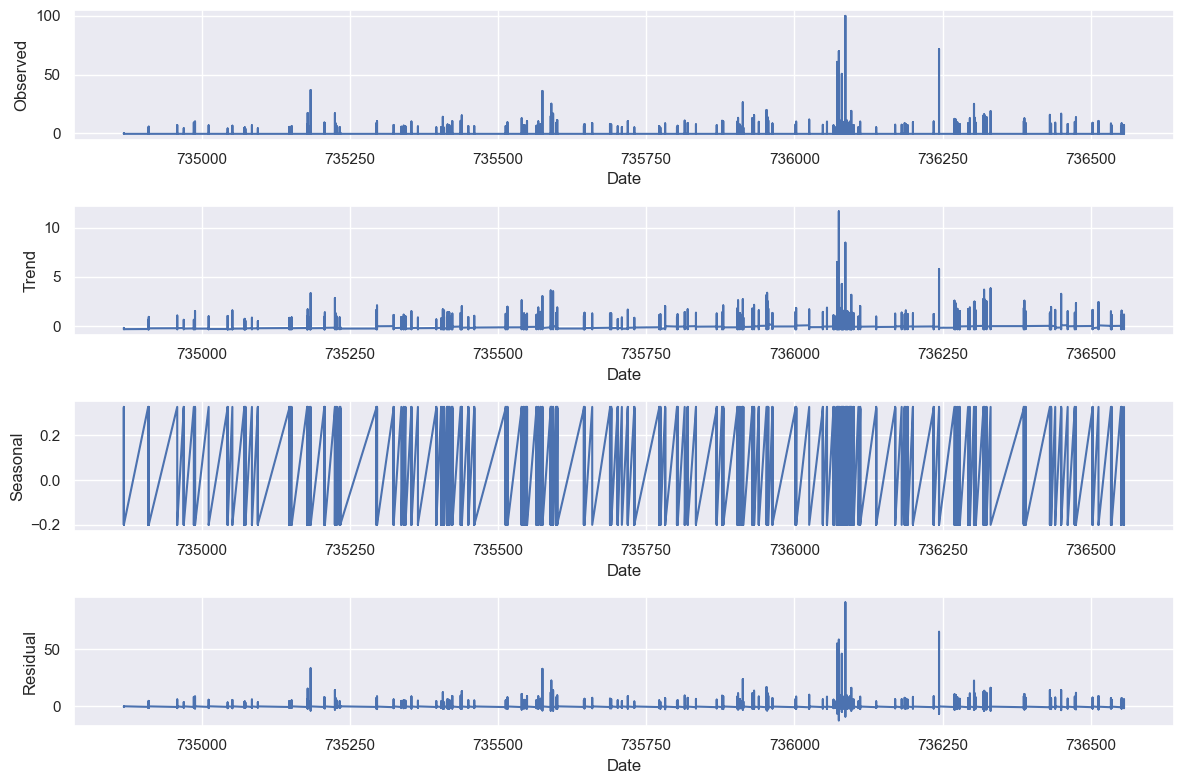

In [74]:
period = 12  # Adjust based on your data's periodicity

# Perform seasonal decomposition
result = seasonal_decompose(time_series_data, model='additive', period=period)

# Plot the decomposition components (trend, seasonal, residual)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.xlabel('Date')
plt.ylabel('Observed')
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()


#### Testing for stationarity

In [75]:

# result = adfuller(time_series_data)
# print("The result of adfuller function:",result)
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])

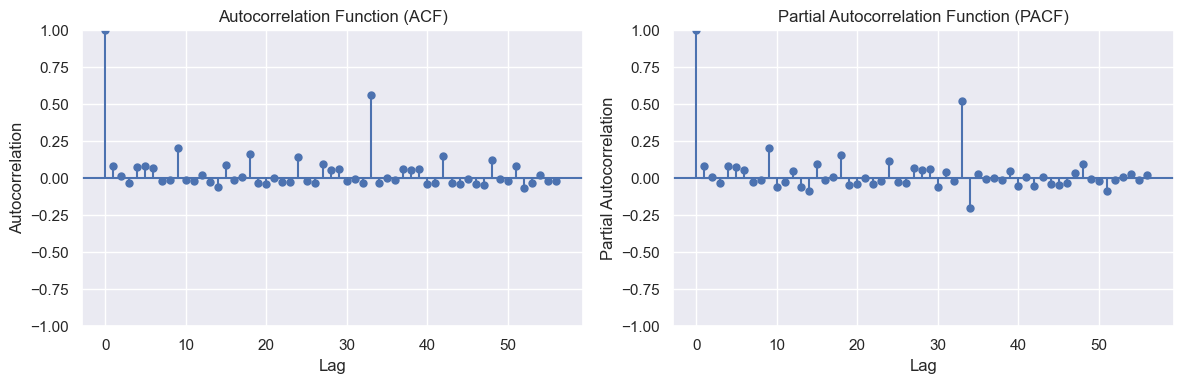

In [76]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF (Autocorrelation Function)
plot_acf(time_series_data,ax=ax1)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF (Partial Autocorrelation Function)
plot_pacf(time_series_data,ax=ax2)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


#### Modeling ARIMA

In [77]:


def evaluate_arima_model(data, p, d, q):
    # Split the data into training and validation sets
    train_size = int(len(data) * 0.8)
    train, valid = data[0:train_size], data[train_size:]
    
    # Fit the ARIMA model to the training data
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    
    # Make predictions on the validation set
    y_pred = model_fit.forecast(steps=len(valid))
    
    # Calculate performance metrics
    mae = mean_absolute_error(valid, y_pred)
    mse = mean_squared_error(valid, y_pred)
    rmse = np.sqrt(mse)
    
    # Print the performance metrics
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


In [78]:
evaluate_arima_model(time_series_data, p=1, d=1, q=1)

Mean Absolute Error (MAE): 0.49
Mean Squared Error (MSE): 1.30
Root Mean Squared Error (RMSE): 1.14


### SARIMA

In [79]:
# Fit the SARIMA(1,0,0) model 
order = (4, 0, 0)
seasonal_order = (0, 0, 0, 0)  # Since it's SARIMA(1,0,0), seasonal order is (0,0,0,0)

sarima_model = SARIMAX(data_df['sales'], order=order, seasonal_order=seasonal_order)
result = sarima_model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:               322047
Model:               SARIMAX(4, 0, 0)   Log Likelihood             -454548.067
Date:                Tue, 03 Oct 2023   AIC                         909106.134
Time:                        14:26:24   BIC                         909159.546
Sample:                             0   HQIC                        909121.536
                             - 322047                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0861      0.000    421.487      0.000       0.086       0.087
ar.L2          0.0103      0.001      7.399      0.000       0.008       0.013
ar.L3         -0.0404      0.002    -24.595      0.0

### **Regression Based Modeling**

#### Split the Dataset into Independent and Dependent

In [80]:
# split it according to our feature engineering
X = data_df.drop(['sales', 'transactions'], axis=1)
y = data_df[['sales', 'transactions']]

#### Generate Training and Validation sets

In [81]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

#### Model and Evaluate Performance

In [82]:
def checkModelPerformane(model):
    model.fit(x_train.values, y_train.values)
    
    pred = model.predict(x_valid.values)
    
    print("mean_squared_error: ",np.sqrt(mean_squared_error(y_valid.values, pred))) 
    print("mean_absolute_error: ", np.sqrt(mean_absolute_error(y_valid.values, pred)))

### Linear regression

In [83]:
print("LinearRegression")
checkModelPerformane(LinearRegression())

LinearRegression


mean_squared_error:  0.6176269940967976
mean_absolute_error:  0.5334351453744406


### Random forests

In [84]:
print("Random Forest")
checkModelPerformane(RandomForestRegressor(random_state=42))

Random Forest


mean_squared_error:  0.40218039854622817
mean_absolute_error:  0.23812722771140582


## **Phase 7: Model Fine Tuning**

### **Hyperparameter Tuning**

- Optimize model hyperparameters to improve performance (e.g., grid search or random search)

In [85]:

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor(random_state=42)
 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(x_train.values, y_train.values)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

### **Evaluating the best model parameters**

In [86]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [87]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

### **Model Selection**

- Compare the performance of different models and select the best one

In [88]:
test = pd.read_csv("../data/test.csv", parse_dates=['date'])

### **Final Prediction on Test set**

In [89]:
final_model = grid_search.best_estimator_

# load and process data
test = pd.read_csv("../data/test.csv", parse_dates=['date'])

pipe_processing2 = Pipeline([
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])

test_df = pipe_processing2.fit_transform(test)
# final_predictions = final_model.predict(test_df)

split_data -> init
process_data -> init
join_df -> init


### **REFERENCES**

- Time Series Analysis with Python cook, by Tarek A. Atwan
- Hands-on Data analys with Pandas, by Stephanie Molin
- Hands on Machine learning by Aurelien Geron